In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, math
import tensorflow as tf
from sklearn.neighbors import BallTree
import pickle
import importlib
import model
importlib.reload(model)
from model import SearchModel

In [2]:
batch_size = 32
img_size = (128, 128)
data_dir = '/Users/amondal/Documents/datasets/Natural Images/natural_images'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=42,
                                                               image_size=img_size,
                                                               batch_size=batch_size)

Found 6899 files belonging to 8 classes.
Using 5520 files for training.


In [4]:
validn_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                seed=42,
                                                                image_size=img_size,
                                                                batch_size=batch_size)

Found 6899 files belonging to 8 classes.
Using 1379 files for validation.


In [5]:
num_classes = len(train_ds.class_names)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_pf = train_ds.prefetch(buffer_size=AUTOTUNE)
validn_ds_pf = validn_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
img_shape = img_size + (3,)
model_obj = SearchModel(full_model_path='../model/image_search_model/1', img_shape=img_shape, epochs=1, learning_rate=0.001)

In [8]:
model_obj.init(num_classes)

In [9]:
model_obj.fit(train_ds_pf, validn_ds_pf)

173/173 [==============================] - 143s 810ms/step - loss: 0.2573 - accuracy: 0.9152 - val_loss: 0.0411 - val_accuracy: 0.9855

Epoch 00001: saving model to ../model/image_search_model/1


/usr/local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../model/image_search_model/1/assets


/usr/local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../model/image_search_model/1/assets


In [10]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [11]:
filenames = sorted(get_file_list(data_dir))

In [14]:
embeddings = np.empty(shape=(0, 2048))

batch_size = 128
num_batches = int(math.ceil(float(len(filenames))/batch_size))

for i in range(num_batches):
    files = filenames[i*batch_size:min((i+1)*batch_size, len(filenames))]
    images = []
    
    for file in files:
        img = tf.keras.preprocessing.image.load_img(file, target_size=img_size)
        images.append(tf.keras.preprocessing.image.img_to_array(img))
    
    embeddings = np.concatenate((embeddings, model_obj.predict_on_batch(np.array(images))), axis=0)

# all_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir, shuffle=False, image_size=img_size, batch_size=128)

# for image_batch, _ in all_dataset.as_numpy_iterator():
#     embeddings = np.concatenate((embeddings, model_obj.predict_on_batch(image_batch)), axis=0)

In [15]:
embeddings.shape

(6899, 2048)

In [ ]:
with open('model/embeddings.pkl', 'wb') as f:
    pickle.dump((embeddings, filenames), f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
tree = BallTree(embeddings, leaf_size=5)

In [ ]:
with open('model/ball_tree.pkl', 'wb') as f:
    pickle.dump(tree, f, protocol=pickle.HIGHEST_PROTOCOL)

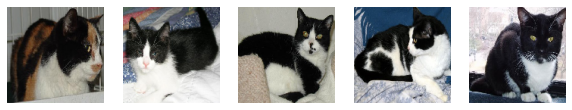

In [18]:
dist, ind = tree.query(embeddings[2333:2334], k=5)

plt.figure(figsize=(10, 10))

i = 0
for idx in ind[0]:
    ax = plt.subplot(1, len(ind[0]), i+1)
    file = filenames[idx]
    img = tf.keras.preprocessing.image.load_img(file, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    plt.imshow(img_array / 255)
    plt.axis('off')
    i += 1
    
plt.savefig('similar_images.png')

In [19]:
filenames[0]

'/Users/amondal/Documents/datasets/Natural Images/natural_images/airplane/airplane_0000.jpg'

In [ ]:
!pip3 freeze >requirements.txt

In [ ]:
resource "aws_iam_role" "notebook_iam_role" {
  name = "sagemaker-notebook-role-image-search"

  assume_role_policy = <<EOF
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "",
      "Effect": "Allow",
      "Principal": {
        "Service": "sagemaker.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}
EOF
}

resource "aws_iam_policy_attachment" "sm_full_access_attach" {
  name = "sagemaker-full-access-attachment-image-search"
  roles = [aws_iam_role.notebook_iam_role.name]
  policy_arn = "arn:aws:iam::aws:policy/AmazonSageMakerFullAccess"
}

resource "aws_sagemaker_notebook_instance_lifecycle_configuration" "notebook_config" {
  name = "sagemaker-lifecycle-config-image-search"
  on_create = filebase64("../terraform-scripts/on-create.sh")
  on_start = filebase64("../terraform-scripts/on-start.sh")
}

resource "aws_sagemaker_code_repository" "git_repo" {
  code_repository_name = "image-search"
  
  git_config {
    repository_url = "https://github.com/funktor/image-search.git"
  }
}

resource "aws_sagemaker_notebook_instance" "notebook_instance" {
  name = "image-search-sagemaker-nb-instance"
  role_arn = aws_iam_role.notebook_iam_role.arn
  instance_type = "ml.t2.medium"
  lifecycle_config_name = aws_sagemaker_notebook_instance_lifecycle_configuration.notebook_config.name
  default_code_repository = aws_sagemaker_code_repository.git_repo.code_repository_name
}